In [1]:
import numpy as np 
import pandas as pd 
from glob import glob 
import cv2
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import math
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
pd.set_option("display.max_rows", 101)
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["font.size"] = 15
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

## Check the input files 

In [2]:
import os
print(os.listdir("../input/severstal-steel-defect-detection"))

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']


## Load train data

In [3]:
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train_df.shape

(7095, 3)

In [4]:
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

## Check train and test image files

In [5]:
# set paths to train and test image datasets
TRAIN_PATH = '../input/severstal-steel-defect-detection/train_images/'
TEST_PATH = '../input/severstal-steel-defect-detection/test_images/'

#glob module is used to retrieve files/pathnames matching a specified pattern. 
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))
print("\nThe path of the first 5 train images:")
for i in range(5): print(train_fns[i])
    
print("\nThe path of the first 5 test images:")
for i in range(5): print(test_fns[i])

There are 12568 images in the train set.
There are 5506 images in the test set.

The path of the first 5 train images:
../input/severstal-steel-defect-detection/train_images/0002cc93b.jpg
../input/severstal-steel-defect-detection/train_images/00031f466.jpg
../input/severstal-steel-defect-detection/train_images/000418bfc.jpg
../input/severstal-steel-defect-detection/train_images/000789191.jpg
../input/severstal-steel-defect-detection/train_images/0007a71bf.jpg

The path of the first 5 test images:
../input/severstal-steel-defect-detection/test_images/0000f269f.jpg
../input/severstal-steel-defect-detection/test_images/000ccc2ac.jpg
../input/severstal-steel-defect-detection/test_images/002451917.jpg
../input/severstal-steel-defect-detection/test_images/003c5da97.jpg
../input/severstal-steel-defect-detection/test_images/0042e163f.jpg


## How many images have defects in the train set?
train_df only contains the images that have defects.  

In [6]:
num_image_defects = len(train_df.ImageId.unique())
num_image_noDefects= len(train_fns) - num_image_defects

print("Number of images with defects：{}".format(num_image_defects))
print("Number of images with no defect：{}".format(num_image_noDefects))

Number of images with defects：6666
Number of images with no defect：5902


## For how many images have defect x? 

In [7]:
train_df.groupby('ClassId').count().reset_index()[["ClassId","ImageId"]]

ClassId  ImageId
0        1      897
1        2      247
2        3     5150
3        4      801

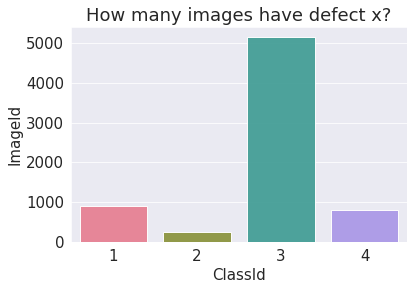

In [8]:
sns.barplot(data = train_df.groupby('ClassId').count().reset_index(),
            x = 'ClassId',
            y = 'ImageId',
            ci = None,  
            alpha = 0.95, 
            palette = 'husl');
plt.tight_layout()
plt.title("How many images have defect x?")
plt.xticks(rotation = 0)
plt.show()

## How many defects each image has?

In [9]:
tt = train_df.groupby('ImageId')['ClassId'].count().reset_index()\
   .sort_values(by = 'ClassId').rename(columns={'ClassId':'Number_of_Classes'})

Check first 5 and last 5 images

In [10]:
tt.iloc[np.r_[0:5,-5:-1]]

ImageId  Number_of_Classes
0     0002cc93b.jpg                  1
4365  a831d2806.jpg                  1
4364  a8312b3b0.jpg                  1
4363  a82b34c33.jpg                  1
4362  a826d9481.jpg                  1
2025  4edc8b817.jpg                  2
497   139b7e692.jpg                  2
1706  42877dc1a.jpg                  2
5740  db4867ee8.jpg                  3

In [11]:
tt.groupby('Number_of_Classes').count().reset_index()\
                   .rename(columns={'ImageId':'Number_of_Images'})

Number_of_Classes  Number_of_Images
0                  1              6239
1                  2               425
2                  3                 2

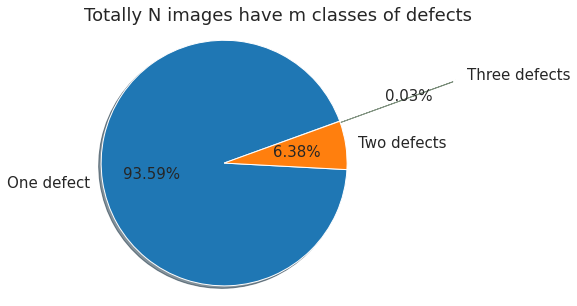

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(tt.groupby('Number_of_Classes').count().ImageId, autopct='%1.2f%%', 
       labels = ['One defect', 'Two defects', 'Three defects'],
       explode=(0,0,1), shadow=True, startangle=20)
ax.axis('equal')
ax.set_title('Totally N images have m classes of defects')

plt.show()

## Check Image Size

In [13]:
from PIL import Image

def get_image_sizes(path):
    widths = []
    heights = []
    images = sorted(glob(path + '*.jpg'))
    
    for im in range(0, len(images)):
        image = Image.open(images[im])
        width, height = image.size
        
        widths.append(width)
        heights.append(height)
        
    return max(widths),min(widths), max(heights),min(heights)

# get sizes of images from test and train sets
train_widths_max,train_widths_min, train_heights_max,train_heights_min = get_image_sizes(TRAIN_PATH)
test_widths_max,test_widths_min, test_heights_max, test_heights_min = get_image_sizes(TEST_PATH)

In [14]:
print('Max/Min width & Hight for training set： {}/{}, {}/{}'
      .format(train_widths_max,train_widths_min, train_heights_max,train_heights_min))
print('Max/Min width & Hight for testing  set： {}/{}, {}/{}'
      .format(test_widths_max,test_widths_min, test_heights_max,test_heights_min))

Max/Min width & Hight for training set： 1600/1600, 256/256
Max/Min width & Hight for testing  set： 1600/1600, 256/256


In [15]:
train_flist = os.listdir(TRAIN_PATH) 
train_flist[0:2]

['f1bd3a48a.jpg', '55042415c.jpg']

## Images with multiple Defects
 '[3, 4]'代表具有3、4标记的图片


0:5902
1:897
2:247
3:5150
4:801
[3, 4]:284
[1, 2]:35
[1, 3]:91
[2, 3]:14
[2, 4]:1
[1, 2, 3]:2


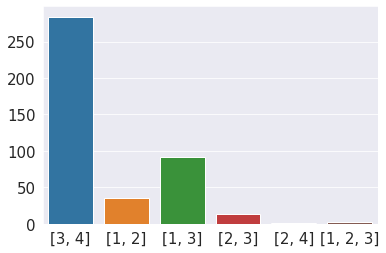

In [16]:
image_defects = train_df['ImageId'].unique().tolist()
image_no_defects=[item for item in train_flist if item not in image_defects]

images_class_num = {'0':0,'1':0,'2':0,'3':0,'4':0}
images_class = {'0':[],'1':[],'2':[],'3':[],'4':[]}
images_mulitlabel = {}
images_mulitlabel_num = {}

images_class_num['0'] = len(image_no_defects)
images_class['0'] = image_no_defects

for i in range(1,5):
    name = str(i)
    images_class_num[name] = (train_df.ClassId == i).sum()
    images_class[name] = [x for x in train_df.ImageId[train_df.ClassId == i]]

for key, value in images_class_num.items():
    print('{key}:{value}'.format(key=key,value=value))

for i in image_defects:
    # filter to select rows contains the image 
    classid = train_df.ClassId[train_df.ImageId==i]
    # if more than one row, it means the image has more than one defect
    if len(classid)>1:
        # add image to image_multilabel
        classid = str(classid.tolist())
        if str(classid) not in images_mulitlabel.keys():
            images_mulitlabel[classid] = [i]
        else:
            images_mulitlabel[classid].append(i)

            #how many images in each multilabel
images_mulitlabel_num = images_mulitlabel.copy()

for i in images_mulitlabel_num:
    images_mulitlabel_num[i] = len(images_mulitlabel_num[i])

for key, value in images_mulitlabel_num.items():
    print('{key}:{value}'.format(key=key,value=value))
    
sns.barplot(x=[i for i in images_mulitlabel_num], 
            y=[images_mulitlabel_num[i] for i in images_mulitlabel_num])
plt.show()

## Visualization images and masks

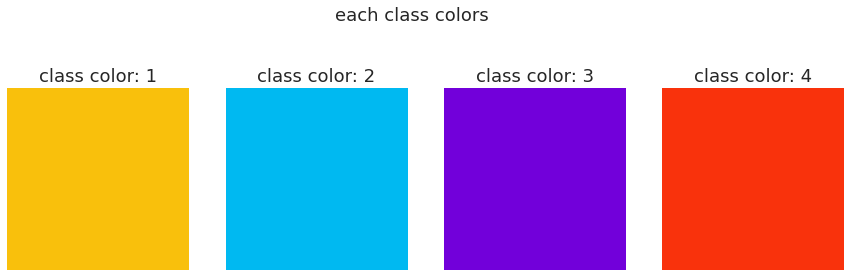

In [17]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 10, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")
plt.show()

In [18]:
def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def name_to_mask(name):
    idx = train_df[train_df.ImageId==name].index.tolist()
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)
    if idx==[]:
        return mask
    
    # rle to mask
    for i in idx:
        rle = train_df.EncodedPixels[i]
        classid = train_df.ClassId[i]
        mask[:, :, classid-1] =  rle2mask(rle, (256,1600,3))
    return mask

def show_mask_image(name):
    mask = name_to_mask(name)
    img = cv2.imread(str(TRAIN_PATH +"/"+ name))
   
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Original Image: " + name)
    ax.imshow(img)
    plt.show()    
    
    if mask.sum() > 0:
        fig, ax = plt.subplots(figsize=(15, 15))
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
        ax.set_title("Image with Masks: " + name)
        ax.imshow(img)
        plt.show()    
    
   


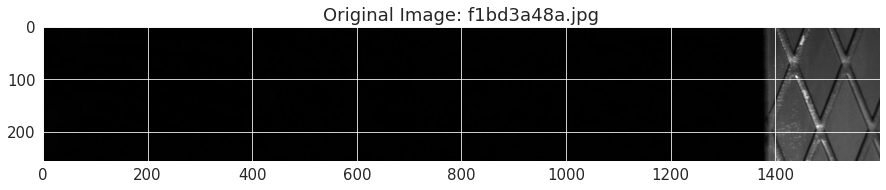

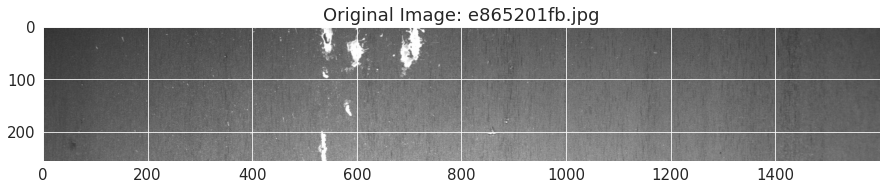

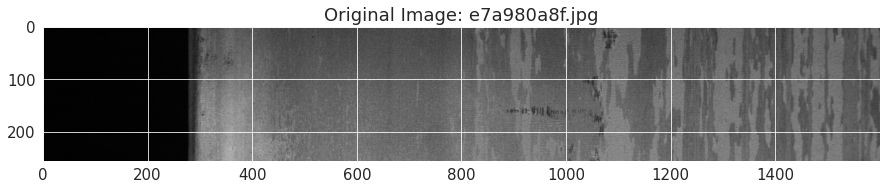

In [19]:
for name in images_class['0'][:3]:
    show_mask_image(name)

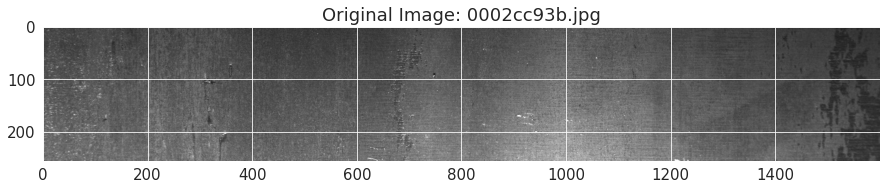

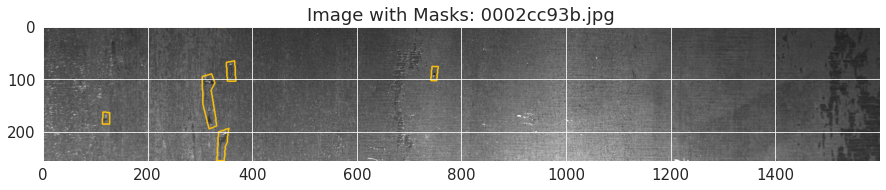

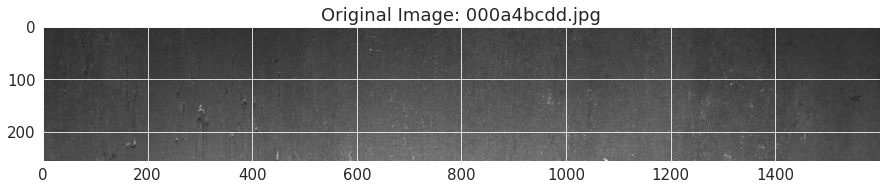

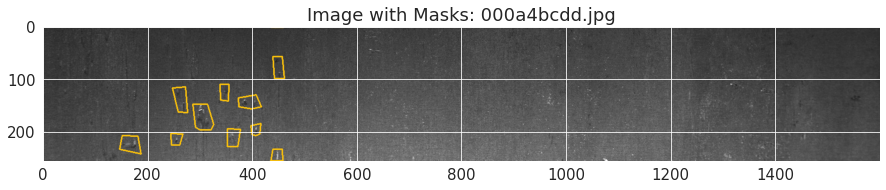

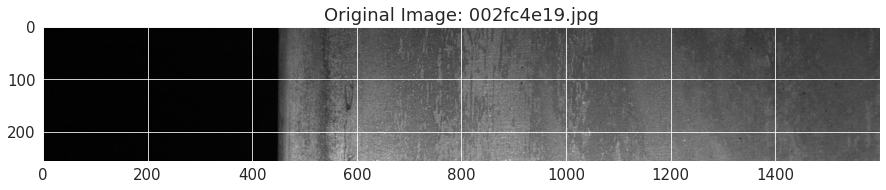

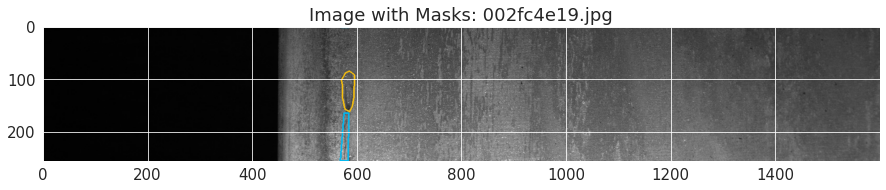

In [20]:
for name in images_class['1'][:3]:
    show_mask_image(name)

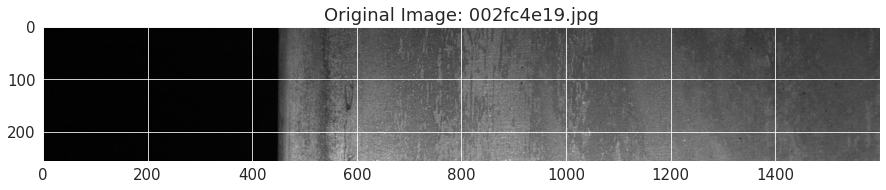

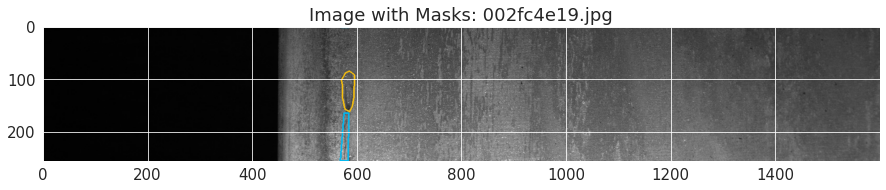

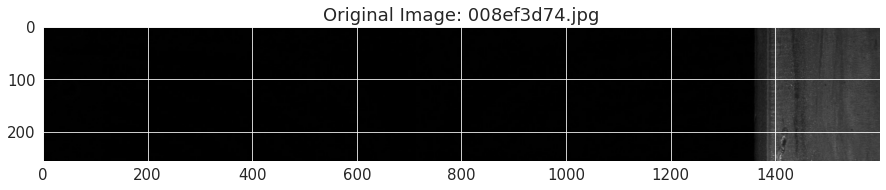

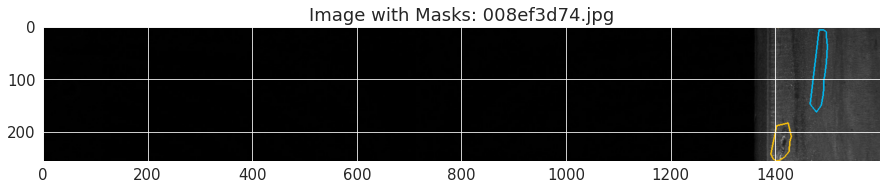

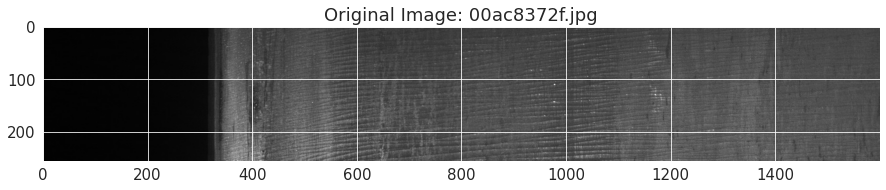

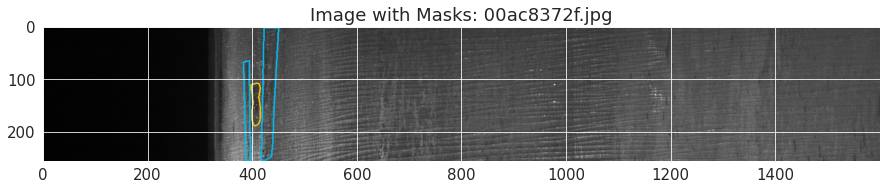

In [21]:
for name in images_class['2'][:3]:
    show_mask_image(name)

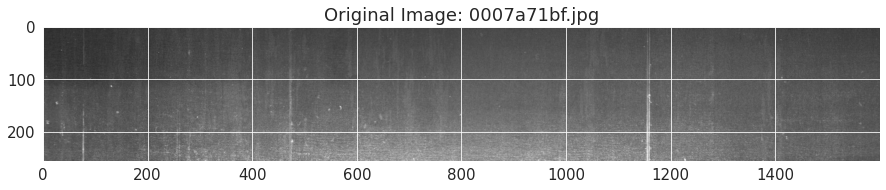

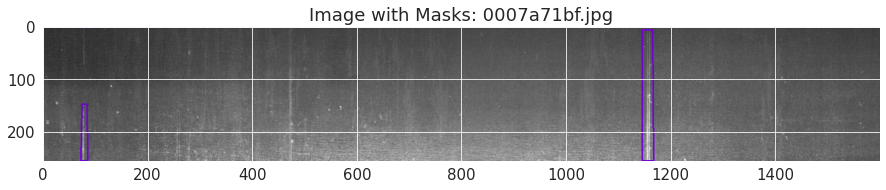

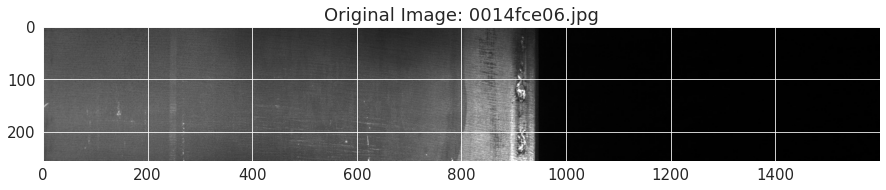

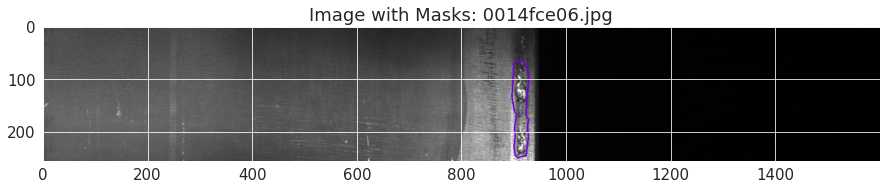

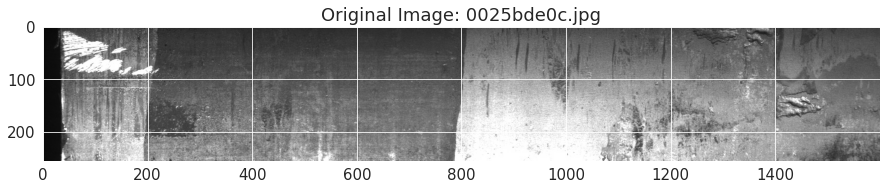

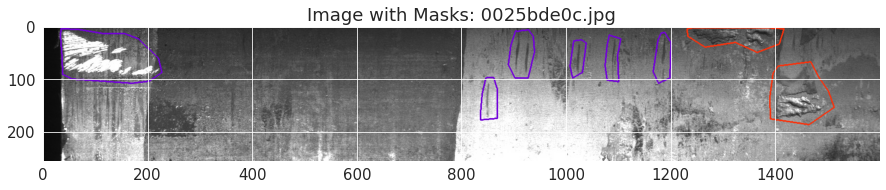

In [22]:
for name in images_class['3'][:3]:
    show_mask_image(name)

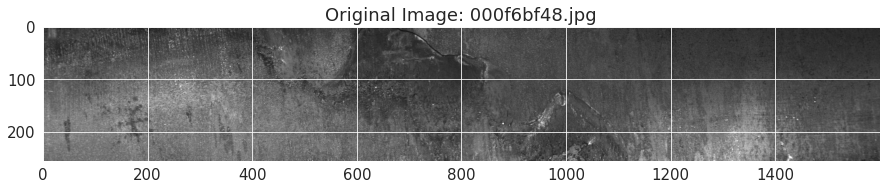

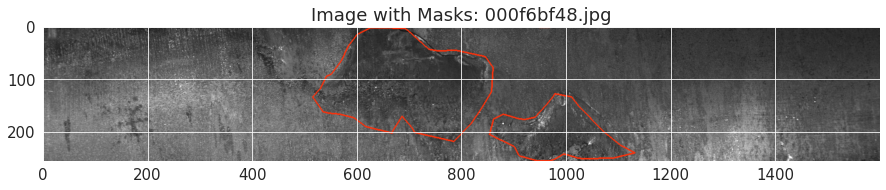

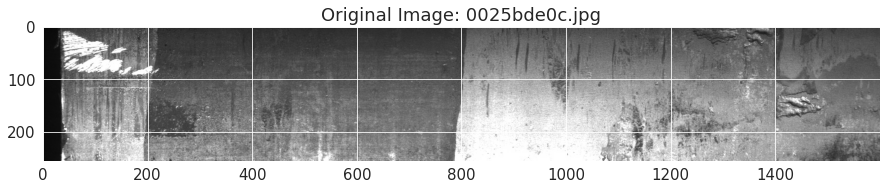

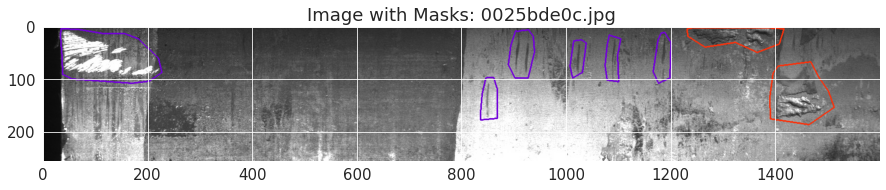

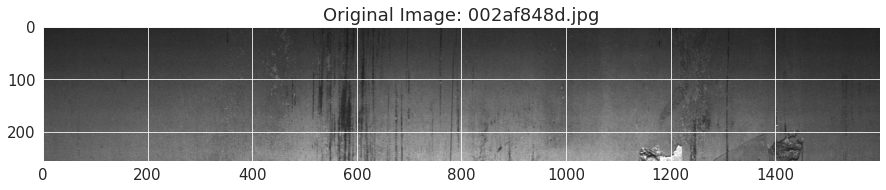

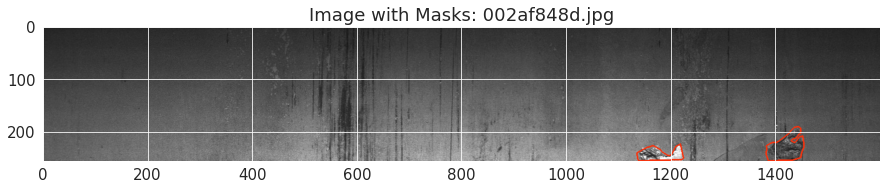

In [23]:
for name in images_class['4'][:3]:
    show_mask_image(name)

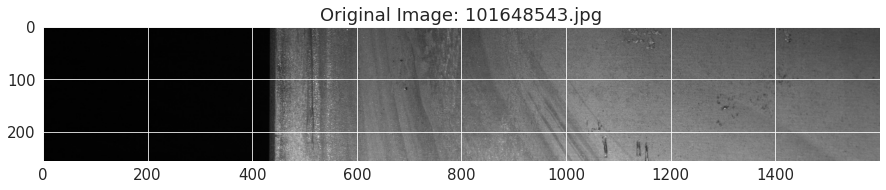

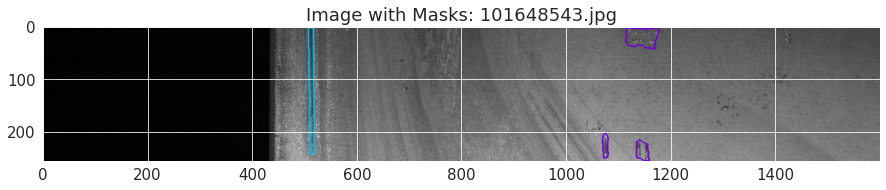

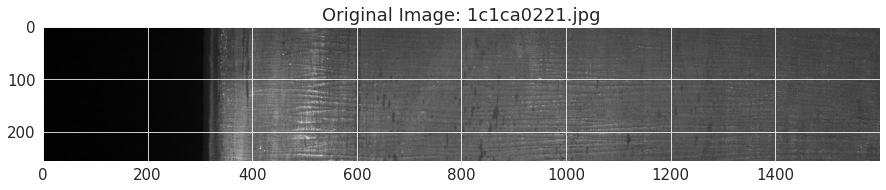

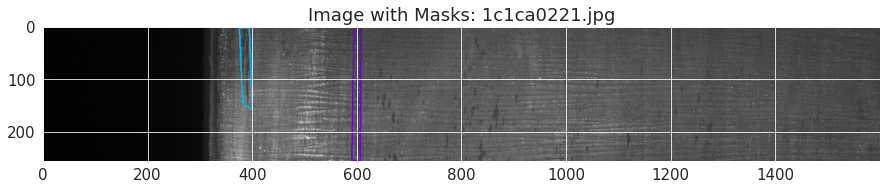

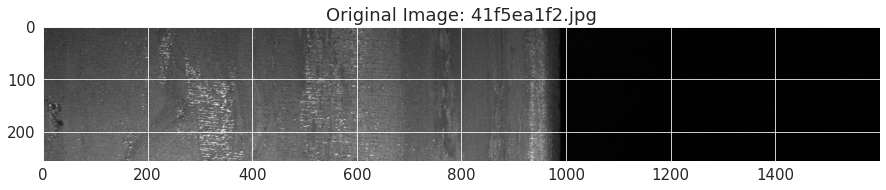

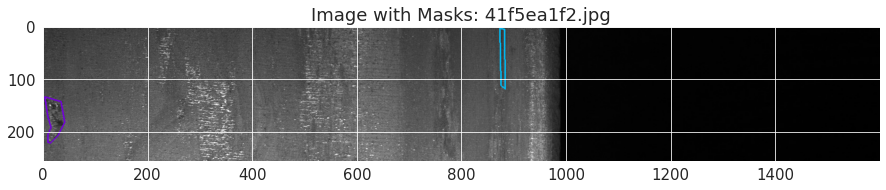

In [24]:
for name in images_mulitlabel['[2, 3]'][:3]:
    show_mask_image(name)

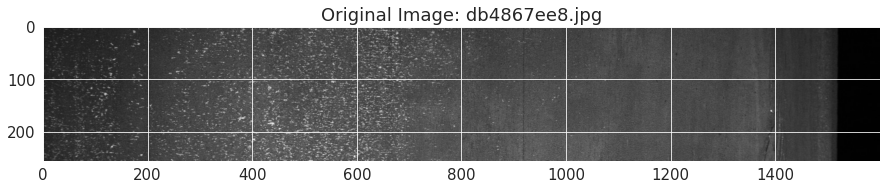

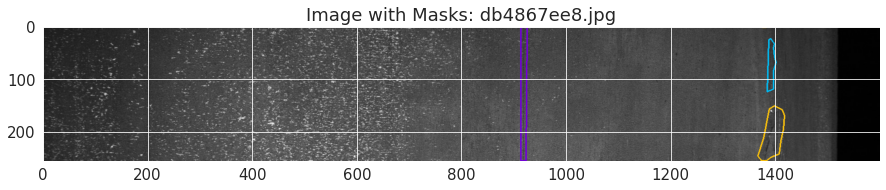

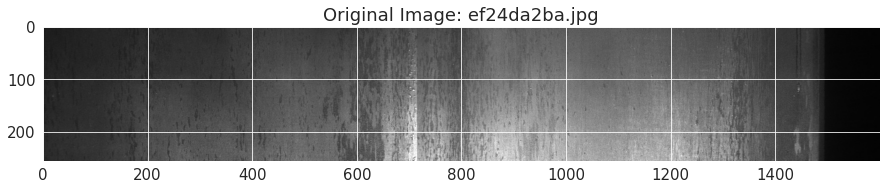

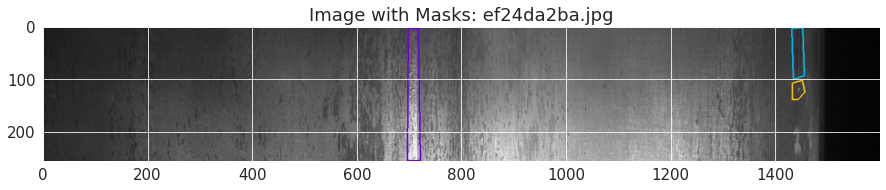

In [25]:
for name in images_mulitlabel['[1, 2, 3]'][:3]:
    show_mask_image(name)